# Visualize Performance of Cell Health Prediction Models

**Gregory Way, 2019**

For regression classification problem. 

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))

## Load Data

In [2]:
results_dir <- "results"
regression_file <- file.path(results_dir, "full_cell_health_regression_results.tsv.gz")
regression_metrics_df <- readr::read_tsv(regression_file, col_types = readr::cols())

coef_file <- file.path(results_dir, "full_cell_health_coefficients.tsv.gz")
full_coef_df <- readr::read_tsv(coef_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform %in% c("raw", "zero-one"))

y_file <- file.path(results_dir, "full_cell_health_y_labels.tsv.gz")
y_df <- readr::read_tsv(y_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform %in% c("raw", "zero-one"))

## Process y Matrix for Plotting

In [3]:
# Combine data for downstream processing
y_binary_subset_true_df <- y_df %>%
    dplyr::filter(y_transform %in% c("raw", "zero-one"),
                  y_type == "y_true")

y_binary_subset_pred_df <- y_df %>%
    dplyr::filter(y_transform %in% c("raw", "zero-one"),
                  y_type == "y_pred")

# Process data for plotting
y_plot_df <- y_binary_subset_true_df %>%
    dplyr::inner_join(y_binary_subset_pred_df,
                      by = c("Metadata_profile_id",
                             "target",
                             "data_type",
                             "shuffle",
                             "y_transform"),
                      suffix = c("_true", "_pred"))

y_plot_df$data_type <- dplyr::recode(y_plot_df$data_type,
                                     "train" = "Train",
                                     "test" = "Test")

print(dim(y_plot_df))
head(y_plot_df, 3)

Warning message:
“`chr_along()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session.”

[1] 99720     9


Metadata_profile_id,recode_target_value_true,target,data_type,shuffle,y_transform,y_type_true,recode_target_value_pred,y_type_pred
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
profile_346,-0.59197918,cc_all_high_n_spots_h2ax_mean,Train,shuffle_true,raw,y_true,0.3170345,y_pred
profile_185,3.27181319,cc_all_high_n_spots_h2ax_mean,Train,shuffle_true,raw,y_true,0.4475188,y_pred
profile_3,-0.06152776,cc_all_high_n_spots_h2ax_mean,Train,shuffle_true,raw,y_true,0.2652313,y_pred


## Process Regression Metrics for Plotting

In [4]:
regression_metrics_df$data_fit <- dplyr::recode(regression_metrics_df$data_fit,
                                                "train" = "Train",
                                                "test" = "Test")

regression_metrics_df$shuffle <- dplyr::recode(regression_metrics_df$shuffle,
                                                "shuffle_true" = "Shuffle",
                                                "shuffle_false" = "Real")

regression_metrics_df <- regression_metrics_df %>%
    dplyr::rename(data_type = data_fit)

regression_metrics_df$mse <- round(regression_metrics_df$mse, 2)

print(dim(regression_metrics_df))
head(regression_metrics_df, 3)

[1] 1120    6


mse,metric,target,data_type,shuffle,y_transform
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
0.60,mse,cc_all_high_n_spots_h2ax_mean,Train,Shuffle,raw
0.39,mse,cc_all_high_n_spots_h2ax_mean,Test,Shuffle,raw
0.09,r_two,cc_all_high_n_spots_h2ax_mean,Train,Shuffle,raw


## Plot a Summary of All Target Variables

In [5]:
mse_df <- regression_metrics_df %>%
    dplyr::filter(metric == "mse",
                  y_transform == "raw",
                  data_type == "Test")

# Take absolute value of mean squared error
# see https://github.com/scikit-learn/scikit-learn/issues/2439
mse_df$mse = abs(mse_df$mse)

# Sort mse by minimum MSE in test set
target_order <- mse_df %>%
    dplyr::filter(data_type == "Test",
                  shuffle == "Real") %>%
    dplyr::arrange(desc(mse)) %>%
    dplyr::select(target)

mse_df$target <- factor(mse_df$target, levels=target_order$target)

print(dim(mse_df))
head(mse_df, 4)

[1] 140   6


mse,metric,target,data_type,shuffle,y_transform
<dbl>,<chr>,<fct>,<chr>,<chr>,<chr>
0.39,mse,cc_all_high_n_spots_h2ax_mean,Test,Shuffle,raw
0.39,mse,cc_all_high_n_spots_h2ax_mean,Test,Real,raw
1.10,mse,cc_all_large_notround_polynuclear_mean,Test,Shuffle,raw
0.42,mse,cc_all_large_notround_polynuclear_mean,Test,Real,raw


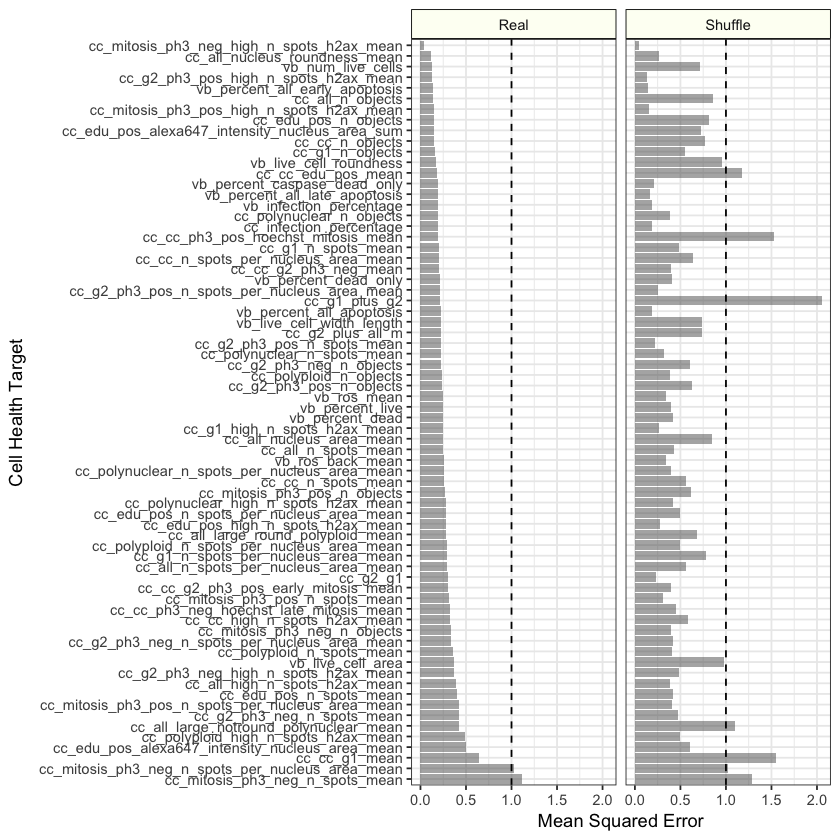

In [6]:
ggplot(mse_df,
       aes(x = target,
           y = mse)) +
    geom_bar(stat = "identity",
             alpha = 0.5,
             position = position_dodge()) +
    facet_grid(~shuffle, scales="free_y") +
    coord_flip() +
    theme_bw() +
    geom_hline(yintercept = 1, linetype = "dashed") +
    ylab("Mean Squared Error") +
    xlab("Cell Health Target") +
    theme(legend.position = "none",
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

file <- file.path("figures", "mse_test_summary.png")
ggsave(file, dpi = 300, width = 7, height = 9)

In [7]:
# Label variables with specific cell health classes
label_file <- file.path("..", "0.generate-profiles", "data", "labels", "feature_mapping_annotated.csv")
label_df <- readr::read_csv(label_file, col_types = readr::cols())

print(dim(label_df))
tail(label_df, 5)

[1] 75  6


original_name,updated_name,feature_type,measurement,maria_thumbs_up,description
<chr>,<chr>,<chr>,<chr>,<int>,<chr>
"pH3 neg, Hoechst cond (late mitosis) - High number of spots gH2AX - Mean per ...",cc_mitosis_ph3_neg_high_n_spots_h2ax_mean,cell_cycle,NA,0,NA
G1/S,cc_g1_s,cell_cycle,NA,0,NA
G2/G1,cc_g2_g1,cell_cycle,NA,1,G1-G2
G1+G2,cc_g1_plus_g2,cell_cycle,NA,0,G1+G2
G2 + All M-phase,cc_g2_plus_all_m,cell_cycle,NA,0,G2+M


In [8]:
# Merge table with target labels
mse_summary_df <- mse_df %>%
    dplyr::left_join(label_df, by = c("target" = "updated_name")) %>%
    dplyr::filter(!is.na(measurement))

# Split shuffle column for scatter plot
mse_spread_df <- mse_summary_df %>% tidyr::spread(shuffle, mse)

head(mse_spread_df, 2)

Warning message:
“Column `target`/`updated_name` joining factor and character vector, coercing into character vector”

metric,target,data_type,y_transform,original_name,feature_type,measurement,maria_thumbs_up,description,Real,Shuffle
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>
mse,cc_all_high_n_spots_h2ax_mean,Test,raw,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,0.39,0.39
mse,cc_all_large_notround_polynuclear_mean,Test,raw,ALL - large not round (polynuclear) - Mean per Well,cell_cycle,toxicity,0,Fraction of cells with large non-round nuclei,0.42,1.10


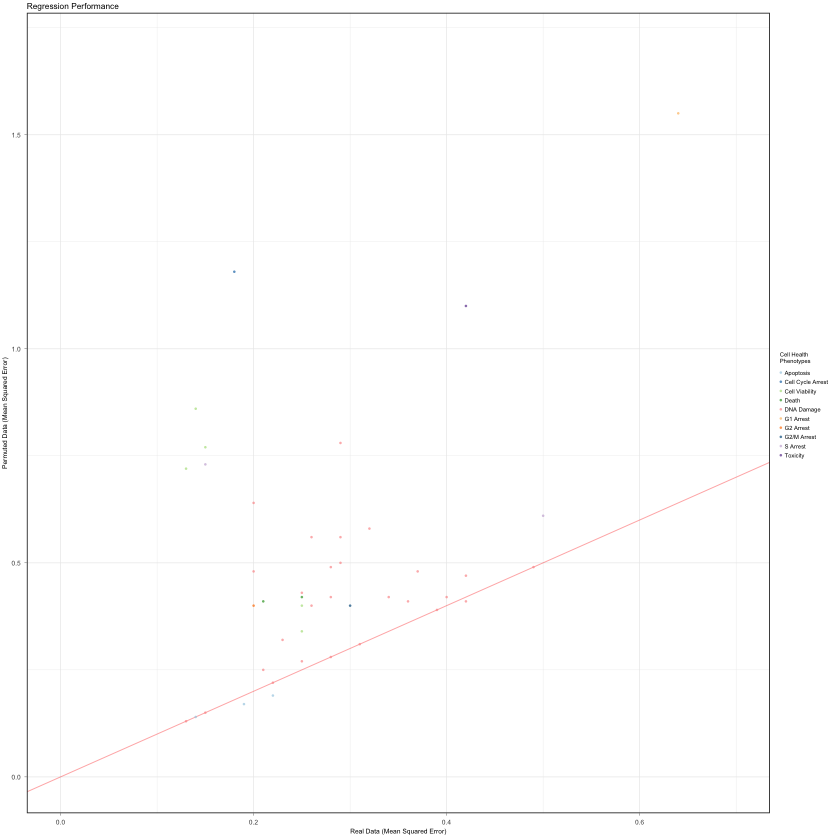

In [9]:
ggplot(mse_spread_df,
       aes(x = Real,
           y = Shuffle,
           color = measurement,)) +
    geom_abline(intercept = 0,
                lwd = 0.1,
                slope = 1,
                linetype = "solid",
                color = "red") +
    geom_point(size = 0.4,
               alpha = 0.7,
               pch = 16) +
    xlim(c(0, 0.7)) +
    ylim(c(0, 1.7)) +
    xlab("Real Data (Mean Squared Error)") +
    ylab("Permuted Data (Mean Squared Error)") +
    ggtitle("Regression Performance") +
    theme_bw() +
    theme(axis.title = element_text(size = 4),
          axis.title.x = element_text(margin = margin(0, 0, 0, 0)),
          axis.title.y = element_text(margin = margin(0, 0, 0, 0)),
          axis.text = element_text(size = 4),
          axis.ticks = element_line(size = 0.1),
          axis.ticks.length = unit(0.05, "cm"),
          plot.title = element_text(size = 5, margin = margin(0, 0, 0, 0)),
          plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "mm"),
          legend.title = element_text(size = 3.5),
          legend.text = element_text(size = 3.5), 
          legend.key.height = unit(0.2, "line"),
          legend.key.width = unit(-0.2, "line"),
          panel.grid.minor = element_line(size = 0.1),
          panel.grid.major = element_line(size = 0.2),
          legend.margin = margin(-5, 7, 0, 0),
          legend.box.margin=margin(0, -5, 5, -5)) +
    scale_color_manual(name = "Cell Health\nPhenotypes",
                       values = c("apoptosis" = "#a6cee3",
                                  "cell_cycle_arrest" = "#1f78b4",
                                  "cell_viability" = "#b2df8a",
                                  "death" = "#33a02c",
                                  "dna_damage" = "#fb9a99", 
                                  "g1_arrest" = "#fdbf6f",
                                  "g2_arrest" = "#ff7f00",
                                  "g2_m_arrest" = "#005c8c",
                                  "s_arrest" = "#cab2d6",
                                  "toxicity" = "#6a3d9a"),
                       labels = c("apoptosis" = "Apoptosis",
                                  "cell_cycle_arrest" = "Cell Cycle Arrest",
                                  "cell_viability" = "Cell Viability",
                                  "death" = "Death",
                                  "dna_damage" = "DNA Damage", 
                                  "g1_arrest" = "G1 Arrest",
                                  "g2_arrest" = "G2 Arrest",
                                  "g2_m_arrest" = "G2/M Arrest",
                                  "s_arrest" = "S Arrest",
                                  "toxicity" = "Toxicity"))

output_file <- file.path("figures", "mse_comparison_scatter.png")
ggsave(output_file, width = 2, height = 1.5, dpi = 300, units = "in")

## Visualize R2 Performance

In [10]:
r2_df <- regression_metrics_df %>%
    dplyr::filter(metric == "r_two",
                  y_transform == "raw",
                  shuffle == "Real")

# Sort mse by minimum MSE in test set
target_order <- r2_df %>%
    dplyr::filter(data_type == "Test",
                  shuffle == "Real") %>%
    dplyr::arrange(mse) %>%
    dplyr::select(target)

r2_df$target <- factor(r2_df$target, levels=target_order$target)

head(r2_df, 4)

mse,metric,target,data_type,shuffle,y_transform
<dbl>,<chr>,<fct>,<chr>,<chr>,<chr>
0.59,r_two,cc_all_high_n_spots_h2ax_mean,Train,Real,raw
0.04,r_two,cc_all_high_n_spots_h2ax_mean,Test,Real,raw
0.50,r_two,cc_all_large_notround_polynuclear_mean,Train,Real,raw
0.58,r_two,cc_all_large_notround_polynuclear_mean,Test,Real,raw


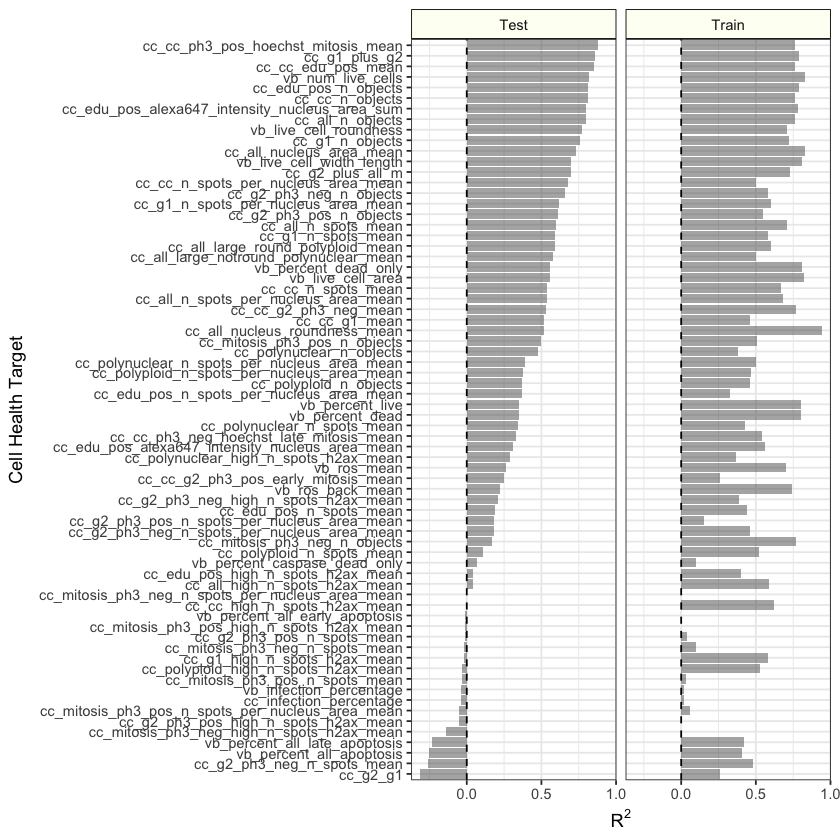

In [11]:
ggplot(r2_df,
       aes(x = target,
           y = mse)) +
    geom_bar(stat = "identity",
             alpha = 0.5,
             position = position_dodge()) +
    facet_grid(~data_type, scales="free_y") +
    coord_flip() +
    theme_bw() +
    geom_hline(yintercept = 0, linetype = "dashed") +
    ylab(bquote(R^2)) +
    xlab("Cell Health Target") +
    theme(legend.position = "none",
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

file <- file.path("figures", "r_squared_model_summary.png")
ggsave(file, dpi = 300, width = 7, height = 9)

## Plot performance metrics for each target variable

In [12]:
label_thresh_value = 0.90

pdf_file <- file.path("figures", "all_regression_performance_metrics.pdf")
pdf(pdf_file, width = 6, height = 8, onefile = TRUE)

for (target in unique(y_plot_df$target)) {
    # Subset all dataframes
    y_subset_df <- y_plot_df %>% dplyr::filter(target == !!target)
    coef_subset_df <- full_coef_df %>% dplyr::filter(target == !!target)
    metrics_subset_df <- regression_metrics_df %>% dplyr::filter(target == !!target)
    
    for (y_transform in unique(y_subset_df$y_transform)) {
        y_subset_transform_df <- y_subset_df %>%
            dplyr::filter(y_transform == !!y_transform)
       
        coef_subset_transform_df <- coef_subset_df %>%
            dplyr::filter(y_transform == !!y_transform,
                          shuffle == "shuffle_false") %>%
            dplyr::mutate(weight_rank = row_number(weight))
        
        metrics_subset_transform_df <- metrics_subset_df %>%
            dplyr::filter(y_transform == !!y_transform)
        
        pred_scatter_gg <-
           ggplot(y_subset_transform_df,
                  aes(x = recode_target_value_true, y = recode_target_value_pred)) +
                geom_point(size = 0.5, alpha = 0.7) +
                facet_grid(data_type~shuffle) +
                theme_bw() +
                xlab("True Values") +
                ylab("Predicted Values") +
                geom_smooth(method='lm', formula=y~x) +
                theme(strip.text = element_text(size = 10),
                      strip.background = element_rect(colour = "black",
                                                      fill = "#fdfff4"))
        
        # Setup labeling thresholds
        non_zero_coef <- coef_subset_transform_df$abs_weight[coef_subset_transform_df$abs_weight > 0]
        label_thresh <- quantile(non_zero_coef, label_thresh_value)
        label_logic <- coef_subset_transform_df$abs_weight > label_thresh

        coef_gg <-
            ggplot(coef_subset_transform_df,
                   aes(x = weight_rank,
                       y = weight)) +
                geom_point(size = 0.2,
                           alpha = 0.6) +
                xlab("Weight Rank") +
                ylab("Weight") +
                geom_text_repel(data = subset(coef_subset_transform_df, label_logic),
                                arrow = arrow(length = unit(0.01, "npc")),
                                box.padding = 0.4,
                                point.padding = 0.1,
                                segment.size = 0.5,
                                segment.alpha = 0.6,
                                size = 1.5,
                                fontface = "italic",
                                aes(label = feature,
                                    x = weight_rank,
                                    y = weight)) +
                theme_bw()
        
         # Build table for plotting performance metrics
        mse_df <- metrics_subset_transform_df %>%
            dplyr::filter(metric == "mse") %>%
            dplyr::select(-metric)
        mse_df$mse = abs(mse_df$mse)

        r2_df <- metrics_subset_transform_df %>%
            dplyr::filter(metric == "r_two") %>%
            dplyr::rename(r2 = mse) %>%
            dplyr::select(-metric)

        metric_table_df <- r2_df %>%
            dplyr::inner_join(mse_df, by=c("target", "data_type", "shuffle", "y_transform")) %>%
            dplyr::select(data_type, shuffle, y_transform, r2, mse) %>%
            dplyr::rename(fit = data_type, transform = y_transform) %>%
            dplyr::arrange(shuffle)

        metric_table_df$shuffle <- dplyr::recode(metric_table_df$shuffle,
                                                 shuffle_true = "True",
                                                 shuffle_false = "False")

        # Plot all performance metrics together with cowplot
        table_theme <- gridExtra::ttheme_default(
            core = list(fg_params=list(cex = 0.7)),
            colhead = list(fg_params=list(cex = 0.8))
        )

        table_gg <- gridExtra::tableGrob(metric_table_df,
                                         theme = table_theme,
                                         rows = NULL)
        
        bottom_row_gg <- cowplot::plot_grid(
            table_gg,
            coef_gg,
            rel_widths = c(0.8, 1),
            nrow = 1
        )
        regression_perf_gg <- cowplot::plot_grid(
            pred_scatter_gg,
            bottom_row_gg,
            rel_heights = c(1, 0.8),
            nrow = 2
        )
        
        target_title <- cowplot::ggdraw() + 
          cowplot::draw_label(
            paste("Performance:", target, "\nTransform:", y_transform),
            fontface = 'bold',
            x = 0,
            hjust = 0
          ) +
          theme(
            plot.margin = margin(0, 0, 0, 7)
          )

        regression_perf_gg <- cowplot::plot_grid(
            target_title,
            regression_perf_gg,
            ncol = 1,
            rel_heights = c(0.1, 1)
        )
        
        # Save figure
        cowplot_file <- file.path("figures",
                                  "target_performance",
                                  "regression",
                                  paste0(target, "_", y_transform, "_performance.png"))

        cowplot::save_plot(filename = cowplot_file,
                           plot = regression_perf_gg,
                           base_height = 6,
                           base_width = 8)

        print(regression_perf_gg)
    }
}

dev.off()

Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”

pdf 
  2